In [ ]:
import re
import os
import sys
import unicodedata
import time

import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Unicode Conversion (https://www.utf8-chartable.de) (first cleaning part)

### Convert all non alpha numerical character into their corresponding utf-8.

In [ ]:
def unicode_converter(string):
    string = string.replace("\\xe2\\x80\\x98", "'")
    string = string.replace("\\xe2\\x80\\x99", "'")
    string = string.replace("\\xe2\\x80\\x9a", "'")
    string = string.replace("\\xe2\\x80\\x9b", "'")
    string = string.replace("\\xe2\\x80\\x9c", '"')
    string = string.replace("\\xe2\\x80\\x9d", '"')
    string = string.replace("\\xc2\\xa0", "\n")
    string = string.replace("\\xc2\\xbd", "1/2")
    string = string.replace("\\xc2\\xb9", "")
    string = string.replace("\\xc3\\xa1", "a")
    string = string.replace("\\xc3\\xa9", "é")
    string = string.replace("\\xc3\\xac", "i")
    string = string.replace("\\xc3\\xad", "i")
    string = string.replace("\\xc3\\xae", "i")
    string = string.replace("\\xc3\\xaf", "i")
    string = string.replace("\\xe2\\x80\\x91", '-')
    string = string.replace("\\xe2\\x80\\x92", '-')
    string = string.replace("\\xe2\\x80\\x93", '-')
    string = string.replace("\\xe2\\x80\\x94", '-')
    string = string.replace("\\xe2\\x80\\xa6", "...")
    string = string.replace("\\xc3\\xb3", "o")
    string = string.replace("\\n", "\n")
    string = string.replace("\\r", "\r")
    string = string.replace("\\'", "'")

    if "\\" in string:
        print("".join(string.split("\\")[1:]))
        input()

    return string

## Loading text files

In [ ]:
print(sys.getdefaultencoding())

root = 'presidents-speeches'
speeches_dict = {}
for path, subdirs, files in os.walk(root):
    s = str(path).split('/')
    if len(s) > 1:
        president = s[1]
        if president not in speeches_dict:
            speeches_dict[president] = []
        for name in files:
            if name != 'initial.txt':
                speeches_dict[president].append((name, unicode_converter(str(open(os.path.join(path, name)).read()))))


utf-8


In [ ]:
print(speeches_dict['Barack Obama'][12][1])

b"My fellow Americans, tonight I want to talk to you about Syria -- why it matters, and where we go from here. Over the past two years, what began as a series of peaceful protests against the repressive regime of Bashar al-Assad has turned into a brutal civil war.
 Over 100,000 people have been killed.
 Millions have fled the country.
 In that time, America has worked with allies to provide humanitarian support, to help the moderate opposition, and to shape a political settlement.
 But I have resisted calls for military action, because we cannot resolve someone else's civil war through force, particularly after a decade of war in Iraq and Afghanistan. The situation profoundly changed, though, on August 21st, when Assad's government gassed to death over a thousand people, including hundreds of children.
 The images from this massacre are sickening:
 Men, women, children lying in rows, killed by poison gas.
 Others foaming at the mouth, gasping for breath.
 A father clutching his dead ch

In [ ]:
print(speeches_dict.keys()) 

dict_keys(['Donald Trump', 'Richard M. Nixon', 'Andrew Jackson', 'Ronald Reagan', 'Bill Clinton', 'George W. Bush', 'Thomas Jefferson', 'Franklin D. Roosevelt', 'George Washington', 'Barack Obama', 'George H. W. Bush'])


## Tokenization

### Cleaning part 2

In [ ]:
lemmatizer = WordNetLemmatizer() # Using the lemmatizer because in general it is more accurate than the stemming
def wordnet_part_of_speech_from_tag(tag): # Part Of Speech Taging
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def clean(text, lemmatize=True, lower=True, stop=True): # Function to lemmatize, remove the stop words and lower it
    text = re.sub("[^A-Za-z0-9]", " ", text)
    text = re.sub("\s+", " ", text)

    word_list = text.split()

    if stop:    
        word_list = [word for word in word_list if not word in stopwords.words('english')]
    
    if lemmatize:
        word_list_clean = []
        for i, word in enumerate(word_list):
            pos = wordnet_part_of_speech_from_tag(pos_tag([word])[0][1])
            if pos is not '':
                word_list_clean.append(lemmatizer.lemmatize(word, pos))
            else:
                word_list_clean.append(word)
    else:
        word_list_clean = word_list

    if lower:
        word_list_clean = [word.lower() for word in word_list_clean]
        
    return word_list_clean

speeches = []
for (president, speech_list) in speeches_dict.items():
    for speech in speech_list:
        speeches.append((speech[1], president, speech[0]))

df = pd.DataFrame(speeches, columns = ['text', 'label', 'title']) # Creating a dataframe to manipulate and proceed the model on it

print("Cleaning...")

start = time.time()

df_clean = df.copy()
df_clean["text"] = df_clean["text"].map(clean)

end = time.time()

print("Cleaning took %.2f seconds" % (end-start))

Cleaning...
Cleaning took 200.64 seconds


In [ ]:
# Let's try multiple vectorizers to see which one has the best effect on the accuracy
vectorizers = {"count": CountVectorizer(), "tfidf": TfidfVectorizer(), "hashing": HashingVectorizer(),
               "count_clean": CountVectorizer(preprocessor=identity, tokenizer=identity, token_pattern="(?u)\b\w\w+\b", lowercase=False),
               "tfidf_clean": TfidfVectorizer(preprocessor=identity, tokenizer=identity, token_pattern="(?u)\b\w\w+\b", lowercase=False),
               "hashing_clean": HashingVectorizer(preprocessor=identity, tokenizer=identity, token_pattern="(?u)\b\w\w+\b", lowercase=False)}

vectorizers["count"].fit(df['text'])
vectorizers["tfidf"].fit(df['text'])
vectorizers["hashing"].fit(df['text'])

vectorizers["count_clean"].fit(df_clean["text"])
vectorizers["tfidf_clean"].fit(df_clean["text"])
vectorizers["hashing_clean"].fit(df_clean["text"])
    
def identity(text):
    return text

def test_models(df, string, vectorizer, iters, clean=False): # Function to test multiple models with and without cleaning it
    print(string + ":")
    scores = {"KN": [], "MNB": [], "SVM": [], "SGD": []}
    for i in range(iters):

        seed = np.random.randint(2**32)
        train, test = train_test_split(df[['text', 'label', 'title']], test_size = 0.2, random_state=seed)
        n_unique = df['label'].value_counts(dropna = False)

        vectorizer.fit(df["text"])

        X_test_vect = vectorizer.transform(test.text)
        y_test = test.label

        X_train_vect = vectorizer.transform(train.text)
        y_train = train.label

        clfKN = KNeighborsClassifier(n_neighbors = len(n_unique), weights = 'distance', algorithm = 'auto')
        clfKN.fit(X_train_vect, train.label)

        predictionKN = clfKN.predict(X_test_vect)
        scores["KN"].append((round(accuracy_score(y_test, predictionKN), 2), seed))

        clfNB = MultinomialNB()
        try:
            clfNB.fit(X_train_vect,train.label)
            predictionNB = clfNB.predict(X_test_vect)

            scores["MNB"].append((round(accuracy_score(y_test, predictionNB), 2), seed))
        except:
            pass

        clfSVM = svm.SVC(tol = 0.00001)
        clfSVM.fit(X_train_vect, train.label)
        scores["SVM"].append((round(accuracy_score(y_test, clfSVM.predict(X_test_vect)), 2), seed))

        clfSGD = SGDClassifier()
        clfSGD.fit(X_train_vect, train.label)
        scores["SGD"].append((round(accuracy_score(y_test, clfSGD.predict(X_test_vect)), 2), seed))

    #print(scores)
    print("\tKNeighbors Model - Best score (out of %d iterations): %.2f (seed: %d)" % (iters, max(scores["KN"], key=lambda score: score[0])[0], max(scores["KN"], key=lambda score: score[0])[1]))
    if len(scores["MNB"]) == 0:
        print("\tNegative values in input: cannot use Multinomial Naive Bayes model")
    else:
        print("\tMultinomial Naive Bayes Model - Best score (out of %d iterations): %.2f (seed: %d)" % (iters, max(scores["MNB"], key=lambda score: score[0])[0], max(scores["MNB"], key=lambda score: score[0])[1]))

    print("\tSupport Vector Machine Model - Best score (out of %d iterations): %.2f (seed: %d)" % (iters, max(scores["SVM"], key=lambda score: score[0])[0], max(scores["SVM"], key=lambda score: score[0])[1]))
    print("\tStochastic Gradient Descent Model - Best score (out of %d iterations): %.2f (seed: %d)" % (iters, max(scores["SGD"], key=lambda score: score[0])[0], max(scores["SGD"], key=lambda score: score[0])[1]))

test_models(df, "Accuracy w/o preprocessing & count vectorizer", vectorizers["count"], 5)
test_models(df, "Accuracy w/o preprocessing & TF-IDF vectorizer", vectorizers["tfidf"], 5)
test_models(df, "Accuracy w/o preprocessing & hashing vectorizer", vectorizers["hashing"], 5)

test_models(df_clean, "Accuracy w/ preprocessing & count vectorizer", vectorizers["count_clean"], 5)
test_models(df_clean, "Accuracy w/ preprocessing & TF-IDF vectorizer", vectorizers["tfidf_clean"], 5)
test_models(df_clean, "Accuracy w/ preprocessing & hashing vectorizer", vectorizers["hashing_clean"], 5)

Accuracy w/o preprocessing & count vectorizer:
	KNeighbors Model - Best score (out of 5 iterations): 0.48 (seed: 2589970025)
	Multinomial Naive Bayes Model - Best score (out of 5 iterations): 0.72 (seed: 2589970025)
	Support Vector Machine Model - Best score (out of 5 iterations): 0.37 (seed: 1939828352)
	Stochastic Gradient Descent Model - Best score (out of 5 iterations): 0.80 (seed: 1516329347)
Accuracy w/o preprocessing & TF-IDF vectorizer:
	KNeighbors Model - Best score (out of 5 iterations): 0.67 (seed: 601129231)
	Multinomial Naive Bayes Model - Best score (out of 5 iterations): 0.24 (seed: 4138887047)
	Support Vector Machine Model - Best score (out of 5 iterations): 0.73 (seed: 2691919022)
	Stochastic Gradient Descent Model - Best score (out of 5 iterations): 0.89 (seed: 2691919022)
Accuracy w/o preprocessing & hashing vectorizer:
	KNeighbors Model - Best score (out of 5 iterations): 0.76 (seed: 848868769)
	Negative values in input: cannot use Multinomial Naive Bayes model
	Sup

##### Looks that the cleaning part and TF_IDF vectorizer here has the best accuracy of 0.93

## Grid Search (Hyperparameter Tuning)

#### Here let's improve our models

In [ ]:
from sklearn.model_selection import GridSearchCV

iters = 5
scores = []
for i in range(iters):
    vectorizer = TfidfVectorizer(preprocessor=identity, tokenizer=identity, token_pattern="(?u)\b\w\w+\b", lowercase=False)
    vectorizer.fit(df_clean["text"])

    train, test = train_test_split(df_clean[['text', 'label', 'title']], test_size = 0.2, random_state=seed)

    X_test_vect = vectorizer.transform(test.text)
    y_test = test.label

    X_train_vect = vectorizer.transform(train.text)
    y_train = train.label

    hyper = {'C':[1],
            'gamma':[0.0001, 0.001, 0.05],
            'kernel':['rbf','linear']
            }

    gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)

    gd.fit(X_train_vect,y_train)
    scores.append((gd.best_score_, gd.best_estimator_, seed))

best_gd_svm = max(scores, key=lambda gd: gd[0])
print(best_gd_svm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(0.7866666666666666, SVC(C=1, gamma=0.0001, kernel='linear'), 1851180451)


In [ ]:
print("Seed:", best_gd_svm[2])
print("Accuracy on train:", round(best_gd_svm[0], 2))
print("Accuracy on test:", round(accuracy_score(y_test, best_gd_svm[1].predict(X_test_vect)), 2))

Seed: 1851180451
Accuracy on train: 0.79
Accuracy on test: 0.83


In [ ]:
from sklearn.model_selection import GridSearchCV

iters = 30
scores = []
for i in range(iters):
    seed = np.random.randint(2**32)

    vectorizer = TfidfVectorizer(preprocessor=identity, tokenizer=identity, token_pattern="(?u)\b\w\w+\b", lowercase=False)
    vectorizer.fit(df_clean["text"])

    train, test = train_test_split(df_clean[['text', 'label', 'title']], test_size = 0.2, random_state=seed)

    X_test_vect = vectorizer.transform(test.text)
    y_test = test.label

    X_train_vect = vectorizer.transform(train.text)
    y_train = train.label

    hyper = {'alpha':[0.0005, 0.001, 0.01, 0.05,0.1,0.3,0.4,0.7,0.8,1],
            }

    gd=GridSearchCV(estimator=MultinomialNB(),param_grid=hyper,verbose=True)

    gd.fit(X_train_vect,y_train)
    scores.append((gd.best_score_, gd.best_estimator_, seed))

best_gd_mnb = max(scores, key=lambda gd: gd[0])
print(best_gd_mnb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each

In [ ]:
print("Seed:", best_gd_mnb[2])
print("Accuracy on train:", round(best_gd_mnb[0], 2))
print("Accuracy on test:", round(accuracy_score(y_test, best_gd_mnb[1].predict(X_test_vect)), 2))

Seed: 3747259452
Accuracy on train: 0.85
Accuracy on test: 0.99


### Best accuracy on test set of 0.99 after tuning hyperparameters... 

# Sentiment Analysis

In [ ]:
presidents_in_order = ["George Washington", "Thomas Jefferson", "Andrew Jackson" , "Franklin D. Roosevelt",
                       "Richard M. Nixon", "Ronald Reagan", "George H. W. Bush", "Bill Clinton", "George W. Bush", "Barack Obama", "Donald Trump"]

analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

speeches_count_pos = {pres: {} for pres in presidents_in_order}
speeches_count_neg = {pres: {} for pres in presidents_in_order}
speeches_count_neu = {pres: {} for pres in presidents_in_order}

for i, row in df.iterrows():
    score = sentiment_analyzer_scores(row["text"])["compound"]
    tag = "Negative" if score < -0.5 else ("Positive" if score > 0.5 else "Neutral")
    year = int(row["title"].split(", ")[1].split("__")[0])
   
    if year not in speeches_count_neg[row["label"]]:
        speeches_count_neg[row["label"]][year] = 0
        speeches_count_pos[row["label"]][year] = 0
        speeches_count_neu[row["label"]][year] = 0

    if tag == "Negative":
        speeches_count_neg[row["label"]][year] += 1
    elif tag == "Positive":
        speeches_count_pos[row["label"]][year] += 1
    else:
        speeches_count_neu[row["label"]][year] += 1

print("Positive dict:", speeches_count_pos)
print("Negative dict:", speeches_count_neg)
print("Neutral dict:", speeches_count_neu)

Positive dict: {'George Washington': {1793: 3, 1796: 4, 1790: 3, 1789: 2, 1794: 3, 1795: 2, 1792: 3, 1791: 1}, 'Thomas Jefferson': {1807: 4, 1802: 3, 1805: 3, 1803: 4, 1806: 4, 1804: 1, 1809: 1, 1801: 3, 1808: 1}, 'Andrew Jackson': {1833: 5, 1830: 4, 1836: 2, 1834: 3, 1837: 1, 1829: 3, 1832: 5, 1835: 1, 1831: 2}, 'Franklin D. Roosevelt': {1945: 3, 1933: 5, 1944: 3, 1937: 5, 1936: 3, 1940: 4, 1943: 3, 1935: 1, 1934: 2, 1941: 6, 1942: 1, 1938: 3, 1939: 1}, 'Richard M. Nixon': {1972: 4, 1971: 4, 1973: 4, 1970: 1, 1952: 1, 1969: 2, 1974: 5}, 'Ronald Reagan': {1985: 3, 1981: 8, 1987: 5, 1984: 8, 1988: 6, 1983: 9, 1982: 7, 1979: 1, 1986: 5, 1976: 1, 1989: 1, 1980: 1, 1964: 1}, 'George H. W. Bush': {1991: 5, 1992: 5, 1990: 6, 1989: 4, 1988: 2, 1993: 1}, 'Bill Clinton': {1993: 11, 1997: 3, 1995: 6, 1999: 2, 1998: 5, 1996: 4, 1994: 3, 2000: 1, 2001: 1}, 'George W. Bush': {2004: 4, 2002: 5, 2001: 6, 2005: 4, 2009: 2, 2006: 2, 2008: 4, 2003: 3, 2007: 3}, 'Barack Obama': {2010: 9, 2011: 8, 2013: 9

In [ ]:
for pres in speeches_count_neu:
    for year in speeches_count_neu[pres]:
        if speeches_count_neu[pres][year] > 0:
            print(pres, "-", year, ":", speeches_count_neu[pres][year])

Bill Clinton - 1999 : 1


# Plotting the sentiment analysis for each President

[(1789, 2), (1790, 3), (1791, 1), (1792, 3), (1793, 3), (1794, 3), (1795, 2), (1796, 4)] 8
[(1801, 3), (1802, 3), (1803, 4), (1804, 1), (1805, 3), (1806, 4), (1807, 4), (1808, 1), (1809, 1)] 9
[(1829, 3), (1830, 4), (1831, 2), (1832, 5), (1833, 5), (1834, 3), (1835, 1), (1836, 2), (1837, 1)] 9
[(1933, 5), (1934, 2), (1935, 1), (1936, 3), (1937, 5), (1938, 3), (1939, 1), (1940, 4), (1941, 6), (1942, 1), (1943, 3), (1944, 3), (1945, 3)] 13
[(1952, 1), (1969, 2), (1970, 1), (1971, 4), (1972, 4), (1973, 4), (1974, 5)] 7
[(1964, 1), (1976, 1), (1979, 1), (1980, 1), (1981, 8), (1982, 7), (1983, 9), (1984, 8), (1985, 3), (1986, 5), (1987, 5), (1988, 6), (1989, 1)] 13
[(1988, 2), (1989, 4), (1990, 6), (1991, 5), (1992, 5), (1993, 1)] 6
[(1993, 11), (1994, 3), (1995, 6), (1996, 4), (1997, 3), (1998, 5), (1999, 2), (2000, 1), (2001, 1)] 9
[(2001, 6), (2002, 5), (2003, 3), (2004, 4), (2005, 4), (2006, 2), (2007, 3), (2008, 4), (2009, 2)] 9
[(2008, 2), (2009, 9), (2010, 9), (2011, 8), (2012, 4), (

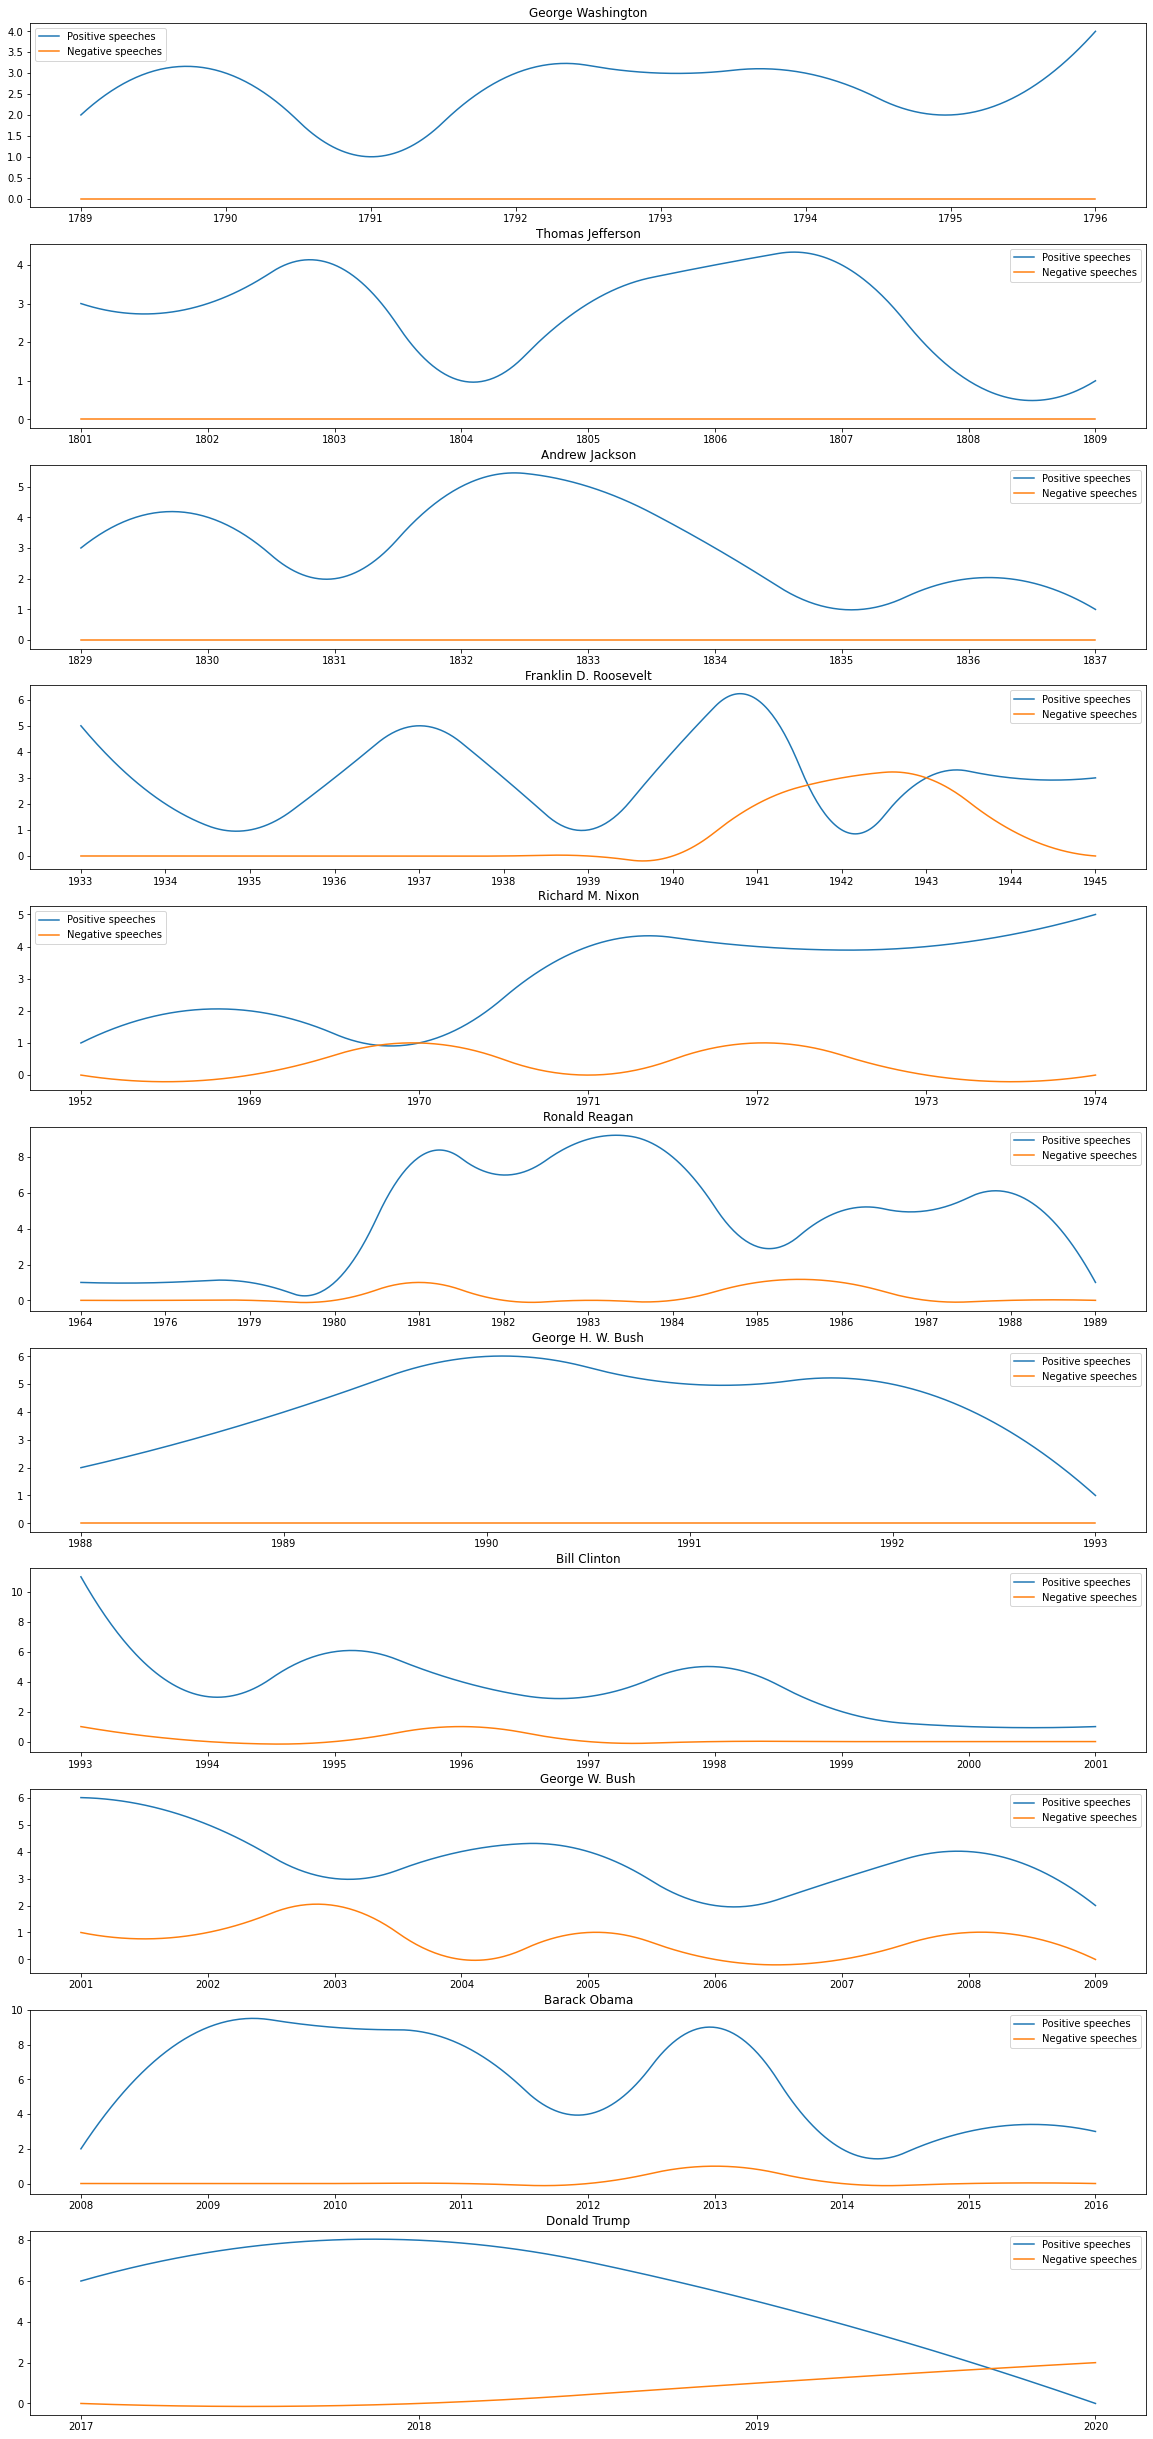

In [ ]:
fig, axes = plt.subplots(len(presidents_in_order), figsize=(20,44))

for i, pres in enumerate(presidents_in_order):
    pres_years_pos = sorted(list(speeches_count_pos[pres].items()), key=lambda item: item[0])
    pres_years_neg = sorted(list(speeches_count_neg[pres].items()), key=lambda item: item[0])

    print(pres_years_pos, len(pres_years_pos))

    x = np.arange(0, len(pres_years_pos))
    x_new = np.linspace(x.min(), x.max(), 500)

    f = interp1d(x, [item[1] for item in pres_years_pos], kind='quadratic')
    y_smooth_pos = f(x_new)

    f = interp1d(x, [item[1] for item in pres_years_neg], kind='quadratic')
    y_smooth_neg = f(x_new)

    axes[i].plot(x_new, y_smooth_pos, label='Positive speeches')
    axes[i].plot(x_new, y_smooth_neg, label='Negative speeches')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels([item[0] for item in pres_years_pos])
    axes[i].set_title(pres)
    axes[i].legend()

plt.show()
print()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d42f6cca-4e71-466f-a1d5-45dcc7619b1d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>